## IBM Quantum Challenge Fall 2021
# Challenge 2: 有機EL分子のエネルギーバンドギャップの計算

<div id='problem'></div>
<div class="alert alert-block alert-info">
    
Quantum Challengeに最適な環境で取り組んでいただくために、右上のアカウントメニューより **light** モードを選択されることをお勧めします。

## はじめに

近年、薄型テレビや携帯電話のディスプレイの材料として、電流を流すと発光する有機EL(有機発光ダイオード)が注目されています。最近の研究([**Gao et al., 2021**](https://www.nature.com/articles/s41524-021-00540-6))では、フェニルスルホニルカルバゾール（PSPCz）分子の高エネルギー状態の電子遷移が注目されており、有機EL技術の熱活性化遅延蛍光（TADF）エミッターとして有用であると考えられています。TADFエミッターは、有機ELの製造に現在使用されている、量子効率が25％に制限された従来の蛍光色素と比較して、内部量子効率が100％の有機ELを実現できる可能性があります。
効率が大幅に向上するということは、携帯電話などの低消費電力機器用の有機ELを製造することが可能になります。また、将来的には、家庭やオフィス、美術館など、あらゆる場所の表面を安価でエネルギー効率の高い光源に変えることができるようになるかもしれません！

<center><img src="resources/JSR_img6_1920w.jpg" width="600"></center>

### なぜ量子コンピューターを使うのでしょうか？

量子コンピューターは、複雑な分子や物質の電子構造や動的特性を研究するための貴重なツールとなる可能性があります。なぜなら、量子力学系のモデル化は、古典的なコンピューターよりも量子デバイス上で行う方が理にかなっているからです。最近のIBM Quantumとパートナー企業による共同研究では、効率的な有機ELのための励起TADF状態の計算の精度を向上させる方法の開発に成功し、商業材料の励起状態の計算に量子コンピュータを適用した世界初の研究事例となりました（参考文献として上記リンク先の論文を参照）。
    
このような背景から、高効率な有機ELの製造に使用される可能性のある工業用化学物質の「励起状態」（高エネルギー状態）の量子計算について説明したいと考えています。

## Challenge

<div class="alert alert-block alert-success">

<b>Goal</b> 

このChallengeのGoalは、量子アルゴリズムを用いて、これらのTADF材料の励起状態エネルギーを確実に予測することです。この課題では、最先端のハイブリッド古典-量子組み込み化学モデリングを導入し、古典的な近似とより正確な量子計算の間で計算負荷を分割できるようにします。
    
1. **Challenge 2a & 2b**: 原子軌道、分子軌道を理解し、アクティブスペース変換を用いて軌道の数を減らす方法を理解します。
2. **Challenge 2c & 2d**: NumPyとVariational Quantum Eigensolver (VQE)を使ってPSPCz分子の基底状態エネルギーを計算します。
3. **Challenge 2e**: 量子運動方程式法(QEOM)アルゴリズムを用いたPSPCzモジュールの励起状態エネルギーを計算します。
4. **Challenge 2f**: Qiskit Runtimeを使って、VQEをクラウド（シミュレーターまたは実際の量子システム）上で実行します。

</div>

<div class="alert alert-block alert-info">

このChallengeを始める前に、電子構造計算をどのように定義するか学ぶために、[<b>Max RossmannekによるQiskit Natureデモセッション<i>](https://youtu.be/UtMVoGXlz04)と[<b>デモのnotebook<i>](https://github.com/qiskit-community/qiskit-application-modules-demo-sessions/blob/main/qiskit-nature/Qiskit_Nature_YouTube_Tutorial.ipynb)をご覧になることをお勧めします。

</div>

### 1. ドライバー


Qiskitで利用可能な古典的な化学のコードへのインターフェースをドライバーと呼びます。例えば、`PSI4Driver`, `PyQuanteDriver`, `PySCFDriver`などがあります。

下のセルでドライバー（与えられた基底セットと分子形状に対するハートリー・フォック計算）を実行することにより、量子アルゴリズムを適用するために必要な分子に関するすべての情報を得ることができます。

In [121]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver

# PSPCz分子
geometry = [['C', [  -0.2316640,    1.1348450,    0.6956120]], # ["atom_name",[x, y, z]]
            ['C', [  -0.8886300,    0.3253780,   -0.2344140]],
            ['C', [  -0.1842470,   -0.1935670,   -1.3239330]],
            ['C', [   1.1662930,    0.0801450,   -1.4737160]],
            ['C', [   1.8089230,    0.8832220,   -0.5383540]],
            ['C', [   1.1155860,    1.4218050,    0.5392780]],
            ['S', [   3.5450920,    1.2449890,   -0.7349240]],
            ['O', [   3.8606900,    1.0881590,   -2.1541690]],
            ['C', [   4.3889120,   -0.0620730,    0.1436780]],
            ['O', [   3.8088290,    2.4916780,   -0.0174650]],
            ['C', [   4.6830900,    0.1064460,    1.4918230]],
            ['C', [   5.3364470,   -0.9144080,    2.1705280]],
            ['C', [   5.6895490,   -2.0818670,    1.5007820]],
            ['C', [   5.4000540,   -2.2323130,    0.1481350]],
            ['C', [   4.7467230,   -1.2180160,   -0.5404770]],
            ['N', [  -2.2589180,    0.0399120,   -0.0793330]],
            ['C', [  -2.8394600,   -1.2343990,   -0.1494160]],
            ['C', [  -4.2635450,   -1.0769890,    0.0660760]],
            ['C', [  -4.5212550,    0.2638010,    0.2662190]],
            ['C', [  -3.2669630,    0.9823890,    0.1722720]],
            ['C', [  -2.2678900,   -2.4598950,   -0.3287380]],
            ['C', [  -3.1299420,   -3.6058560,   -0.3236210]],
            ['C', [  -4.5179520,   -3.4797390,   -0.1395160]],
            ['C', [  -5.1056310,   -2.2512990,    0.0536940]],
            ['C', [  -5.7352450,    1.0074800,    0.5140960]],
            ['C', [  -5.6563790,    2.3761270,    0.6274610]],
            ['C', [  -4.4287740,    3.0501460,    0.5083650]],
            ['C', [  -3.2040560,    2.3409470,    0.2746950]],
            ['H', [  -0.7813570,    1.5286610,    1.5426490]],
            ['H', [  -0.7079140,   -0.7911480,   -2.0611600]],
            ['H', [   1.7161320,   -0.2933710,   -2.3302930]],
            ['H', [   1.6308220,    2.0660550,    1.2427990]],
            ['H', [   4.4214900,    1.0345500,    1.9875450]],
            ['H', [   5.5773000,   -0.7951290,    3.2218590]],
            ['H', [   6.2017810,   -2.8762260,    2.0345740]],
            ['H', [   5.6906680,   -3.1381740,   -0.3739110]],
            ['H', [   4.5337010,   -1.3031330,   -1.6001680]],
            ['H', [  -1.1998460,   -2.5827750,   -0.4596910]],
            ['H', [  -2.6937370,   -4.5881470,   -0.4657540]],
            ['H', [  -5.1332290,   -4.3740010,   -0.1501080]],
            ['H', [  -6.1752900,   -2.1516170,    0.1987120]],
            ['H', [  -6.6812260,    0.4853900,    0.6017680]],
            ['H', [  -6.5574610,    2.9529350,    0.8109620]],
            ['H', [  -4.3980410,    4.1305040,    0.5929440]],
            ['H', [  -2.2726630,    2.8838620,    0.1712760]]]

molecule = Molecule(geometry=geometry, charge=0, multiplicity=1)

driver = ElectronicStructureMoleculeDriver(molecule=molecule, 
                                           basis='631g*', 
                                           driver_type=ElectronicStructureDriverType.PYSCF)

<div class="alert alert-block alert-success">
    
<b> Challenge 2a</b> 
    
質問：PSPCz分子についての以下の数を調べてください。
    
1. C、H、N、O、S原子の数はいくつですか？
1. 原子の総数はいくつですか？
1. 原子軌道の総数はいくつですか？
1. 分子軌道の総数はいくつですか？   
 
</div>

<div class="alert alert-block alert-info">
    
**どうやって原子軌道を数えますか？**


基底によってその値は、異なります。以下の数値は、このChallengeで使用する`631g*`基底に固有のものです。 

- C: 1s, 2s2p, 3s3p3d  = 1+4+9 = 14

- H: 1s, 2s  = 1+1 = 2

- N: 1s, 2s2p, 3s3p3d  = 1+4+9 = 14

- O: 1s, 2s2p, 3s3p3d  = 1+4+9 = 14

- S: 1s, 2s2p, 3s3p3d, 4s4p = 1+4+9+4 = 18

In [122]:
num_ao = {
    'C': 14,
    'H': 2,
    'N': 14,
    'O': 14,
    'S': 18,
}

##############################
# コードを書いてください(ここから)
num_C_atom = 0
num_H_atom = 0
num_N_atom = 0
num_O_atom = 0
num_S_atom = 0
# num_atoms_total = len(geometry)

for atom_name, _ in geometry:
    if atom_name == "C":
        num_C_atom += 1
    elif atom_name == "H":
        num_H_atom += 1
    elif atom_name == "N":
        num_N_atom += 1
    elif atom_name == "O":
        num_O_atom += 1
    elif atom_name == "S":
        num_S_atom += 1
num_atoms_total = num_C_atom + num_H_atom + num_N_atom + num_O_atom + num_S_atom

num_AO_total = num_C_atom*num_ao["C"] + num_H_atom*num_ao["H"] + num_N_atom*num_ao["N"] + num_O_atom*num_ao["O"] + num_S_atom*num_ao["S"]
# for key, val in num_ao.items():
#     num_AO_total += val
num_MO_total = num_AO_total # 分子軌道 = 原子軌道
        
# コードを書いてください(ここまで)
##############################

answer_ex2a ={
    'C': num_C_atom,
    'H': num_H_atom,
    'N': num_N_atom,
    'O': num_O_atom,
    'S': num_S_atom,
    'atoms': num_atoms_total,
    'AOs': num_AO_total,
    'MOs': num_MO_total
}

print(answer_ex2a)

{'C': 24, 'H': 17, 'N': 1, 'O': 2, 'S': 1, 'atoms': 45, 'AOs': 430, 'MOs': 430}


In [123]:
# 答えを確認して以下のコードで提出します
from qc_grader import grade_ex2a
grade_ex2a(answer_ex2a)

Submitting your answer for 2a. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


上のexerciseで分かったように、PSPCzは大きな分子であり、多くの原子と多くの原子軌道で構成されています。現在の量子システムでは、大きな分子を直接計算することはできません。しかし、今回の計算では、バンドギャップのみに関心があるため、最高被占軌道（HOMO, Highest Ocuppied Molecular Orbital）と最低空軌道（LUMO, Lowest Unocuppied Molecular Orbital）のエネルギーを計算するだけで十分です。ここでは、active space transformer（アクティブスペース変換）と呼ばれる手法を使って、分子軌道の数を2つだけ（HOMOとLUMOのみ）に減らしました：

$$E_g = E_{LUMO} - E_{HOMO}$$


<center><img src="resources/Molecule_HOMO-LUMO_diagram.svg" width="600"></center>


ここでの各円は、軌道上の電子を表しています。HOMOの電子が十分に高い周波数の光やエネルギーを吸収すると、LUMOにジャンプします。

PSPCz分子では、この励起状態を最初の一重項状態と三重項状態のみに限定しています。一重項状態では、系内のすべての電子がスピンペアになっており、空間内で可能な向きは1つだけになります。一重項および三重項の励起状態は、2つの電子のうち一方をより高いエネルギー準位に励起することで形成されます。一重項励起状態では、励起された電子は同じスピンの向きを維持していますが、三重項励起状態では、励起された電子は基底状態の電子と同じスピンの向きを持ちます。

<center><img src="resources/spin.jpg" width="300"><figcaption>Spin in the ground and excited states</figcaption></center>


三重項状態では、電子スピンの1組が不対になるため、軸に対して空間的に3つの向きが可能となります。PSPCz（a, d）とその変種である2F-PSPCz（b, e）および4F-PSPCz（c, f）の三重項状態に最適化された構造のLUMO（a-c）およびHOMO（e-f）軌道は、それぞれ以下のようになります。


<center><img src="resources/oled_paper_fig2.jpg" width="600"></center>

<center><img src="resources/oled_paper_fig1.jpg" width="600"></center>


Active space transformer method（アクティブスペース変換法）を使用することにより、計算を一重項と三重項、つまり可能な限り最小の活性空間に限定することで非コア電子状態を除外し、系の高品質な記述を維持しながら、少数の量子ビットでこのエネルギーを計算するができます。

In [124]:
from qiskit_nature.drivers.second_quantization import HDF5Driver

driver_reduced = HDF5Driver("resources/PSPCz_reduced.hdf5")
properties = driver_reduced.run()
# print(properties)

In [125]:
from qiskit_nature.properties.second_quantization.electronic import ElectronicEnergy, ParticleNumber

electronic_energy = properties.get_property(ElectronicEnergy)
print(electronic_energy)

ElectronicEnergy
	(AO) 1-Body Terms:
		Alpha
		<(430, 430) matrix with 184900 non-zero entries>
		[0, 0] = -11.481107571585675
		[0, 1] = -2.6982522446048134
		[0, 2] = -2.237143188610541
		[0, 3] = 0.0017433998087159669
		[0, 4] = 0.0007741436199762753
		... skipping 184895 entries
		Beta
		<(430, 430) matrix with 184900 non-zero entries>
		[0, 0] = -11.481107571585675
		[0, 1] = -2.6982522446048134
		[0, 2] = -2.237143188610541
		[0, 3] = 0.0017433998087159669
		[0, 4] = 0.0007741436199762753
		... skipping 184895 entries
	(MO) 1-Body Terms:
		Alpha
		<(2, 2) matrix with 4 non-zero entries>
		[0, 0] = -0.4968112637934733
		[0, 1] = 0.00027750088691888997
		[1, 0] = 0.00027750088691825913
		[1, 1] = -0.1843594001763901
		Beta
		<(2, 2) matrix with 4 non-zero entries>
		[0, 0] = -0.4968112637934733
		[0, 1] = 0.00027750088691888997
		[1, 0] = 0.00027750088691825913
		[1, 1] = -0.1843594001763901
	(MO) 2-Body Terms:
		Alpha-Alpha
		<(2, 2, 2, 2) matrix with 16 non-zero entries>
		[0, 0,

In [126]:
pn = properties.get_property(ParticleNumber)
print(pn)

ParticleNumber:
	4 SOs
	1 alpha electrons
		orbital occupation: [1. 0.]
	1 beta electrons
		orbital occupation: [1. 0.]


In [127]:
print(pn.__dir__())

['_name', '_num_spin_orbitals', '_num_alpha', '_num_beta', '_occupation_alpha', '_occupation_beta', '_absolute_tolerance', '_relative_tolerance', '__module__', '__doc__', 'ABSOLUTE_TOLERANCE', 'RELATIVE_TOLERANCE', '__init__', 'num_spin_orbitals', 'num_alpha', 'num_beta', 'num_particles', 'occupation_alpha', 'occupation_beta', '__str__', 'from_legacy_driver_result', 'second_q_ops', 'interpret', '__abstractmethods__', '_abc_impl', '_validate_input_type', 'name', 'log', '__dict__', '__weakref__', '__slots__', '__repr__', '__hash__', '__getattribute__', '__setattr__', '__delattr__', '__lt__', '__le__', '__eq__', '__ne__', '__gt__', '__ge__', '__new__', '__reduce_ex__', '__reduce__', '__subclasshook__', '__init_subclass__', '__format__', '__sizeof__', '__dir__', '__class__']


In [128]:
pn.num_spin_orbitals

4

In [129]:
pn.num_particles

(1, 1)

`(AO) 1-Body Terms`が(430 x 430)の行列を含んでいるのがわかると思います。この行列は、430の原子軌道による430の分子軌道へ変換する元々の分子を表しています。

すでに計算された`ActiveSpaceTransformation`の後、分子軌道の数`(MO) 1-Body Terms`は (2x2)の行列に減ります。

<div class="alert alert-block alert-success">
    
<b> Challenge 2b</b> 
    
質問： Propertyフレームワークを使って以下の質問に答えてください。
    
1. アクティブスペース変換後のシステムの電子の数は何個ですか？
1. 分子軌道の数はいくつですか？
1. スピン起動の数はいくつですか？
1. ジョルダン・ウィグナー変換により、この分子をシミュレートするのに必要な量子ビットはいくつですか？

</div>

In [130]:
from qiskit_nature.properties.second_quantization.electronic import ParticleNumber

##############################
# コードを書いてください(ここから)

pn = properties.get_property(ParticleNumber)

particle_number = sum(pn.num_particles)
num_electron = pn.num_alpha + pn.num_beta
# Each MO can hold up to two electrons, one spin-up (alpha) and one spin-down (beta) electron.
num_MO = 2
num_SO = pn.num_spin_orbitals
# one spin orbital in one qubit
num_qubits = num_SO

# コードを書いてください(ここまで)
##############################

answer_ex2b = {
    'electrons': num_electron,
    'MOs': num_MO,
    'SOs': num_SO,
    'qubits': num_qubits
}

print(answer_ex2b)

{'electrons': 2, 'MOs': 2, 'SOs': 4, 'qubits': 4}


In [131]:
# 答えを確認して以下のコードで提出します
from qc_grader import grade_ex2b
grade_ex2b(answer_ex2b)

Submitting your answer for 2b. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### 2. 電子構造の問題設定

次に、量子ビット（パウリストリング）に変換する前の、フェルミオン演算子のリストを生成するElectronicStructureProblemを作成できます。これは、基底状態の分子システムを定義するための最初のステップです。この[**チュートリアル**](https://qiskit.org/documentation/nature/tutorials/03_ground_state_solvers.html)で、基底状態の解決について詳しく読むことができます。
    
<center><img src="resources/H2_gs.png" width="300"></center>

In [132]:
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem

##############################
# コードを書いてください(ここから)

es_problem = ElectronicStructureProblem(driver_reduced)

# コードを書いてください(ここまで)
##############################

second_q_op = es_problem.second_q_ops()
print(second_q_op[0])

Fermionic Operator
register length=4, number terms=26
  (0.01572205126528473+0j) * ( +_0 -_1 +_2 -_3 )
+ (-0.01572205126528473+0j) * ( +_0 -_1 -_2 +_3 )
+ (0.00027750088691888997+0j) * ( +_0 -_1 )
+ (0.0003149147870892302+0j) * ( +_0 -_1 +_3 -_3 )
+  ...


### 3. 量子ビットへの変換

シミュレーションで使用する変換を定義します。

In [133]:
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper

##############################
# コードを書いてください(ここから)

jw_mapper = JordanWignerMapper()
qubit_converter = QubitConverter(jw_mapper)

# コードを書いてください(ここまで)
##############################

qubit_op = qubit_converter.convert(second_q_op[0])
print(qubit_op)

-0.45781773131305903 * IIII
- 0.009666607989543467 * ZIII
+ 0.12689900731767084 * IZII
+ 0.030293077447785 * ZZII
- 0.009666607989543479 * IIZI
+ 0.03732964036584735 * ZIZI
+ 0.034223590264106186 * IZZI
+ 0.12689900731767084 * IIIZ
+ 0.034223590264106186 * ZIIZ
+ 0.05698995686717464 * IZIZ
+ 0.030293077447785 * IIZZ
+ 0.00014809461815615455 * XXII
+ 0.00014809461815615455 * YYII
- 7.872869677230731e-05 * XXZI
- 7.872869677230731e-05 * YYZI
+ 6.938452207544002e-05 * XXIZ
+ 6.938452207544002e-05 * YYIZ
+ 0.00014809461815615455 * IIXX
- 7.872869677230731e-05 * ZIXX
+ 6.938452207544002e-05 * IZXX
+ 0.00014809461815615455 * IIYY
- 7.872869677230731e-05 * ZIYY
+ 6.938452207544002e-05 * IZYY
+ 0.003930512816321183 * XXXX
+ 0.003930512816321183 * YYXX
+ 0.003930512816321183 * XXYY
+ 0.003930512816321183 * YYYY


### 4. 初期状態を設定

理論のセクションで説明したように、化学の問題における良い初期状態はHF(ハートリー・フォック)状態です。次のように初期化できます：

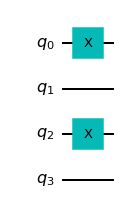

In [134]:
from qiskit_nature.circuit.library import HartreeFock

##############################
# コードを書いてください(ここから)
num_orbitals = pn.num_spin_orbitals
num_particles = pn.num_particles  # [alpha, beta]
init_state = HartreeFock(num_orbitals, num_particles, qubit_converter)

# コードを書いてください(ここまで)
##############################

init_state.draw()

### 5. 試行状態（Ansatz）


最も重要な選択の1つは、基底状態を近似するために選択する量子回路です。
以下では、自分で回路を作るための多くの可能性を秘めたqiskit circuit ライブラリーの例を記載しています。

/opt/conda/lib/python3.8/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


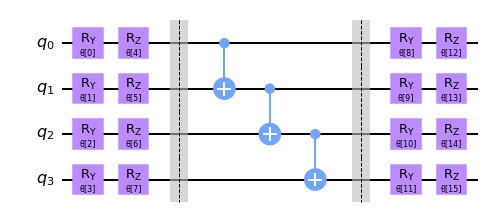

In [135]:
from qiskit.circuit.library import EfficientSU2, TwoLocal, NLocal, PauliTwoDesign
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

##############################
# コードを書いてください(ここから)

ansatz = EfficientSU2(num_qubits=num_qubits, reps=1, entanglement='linear', insert_barriers=True)

# コードを書いてください(ここまで)
##############################

ansatz.decompose().draw()

## 基底状態エネルギーの計算

### NumPyによる計算

学習のために、ハミルトニアン行列を正確に対角化して問題を解くことで、VQEが目指す値を知ることができます。もちろん、この行列の次元は分子軌道の数に従って指数関数的にスケールアップするため、大きな分子に対してNumPyによる計算を試してみると、計算時間がとても遅くなることが確認できます。非常に大規模なシステムの場合、波動関数を保存しようとするとメモリー不足になるでしょう。

<center><img src="resources/vqe.png" width="600"></center>

In [136]:
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_nature.algorithms import GroundStateEigensolver

##############################
# コードを書いてください(ここから)

# numpy_solver = NumPyMinimumEigensolver(operator=None, aux_operators=None, filter_criterion=None) # qubit_op
numpy_solver = NumPyMinimumEigensolver()
numpy_ground_state_solver = GroundStateEigensolver(qubit_converter, numpy_solver)
numpy_results = numpy_ground_state_solver.solve(es_problem)

# コードを書いてください(ここまで)
##############################

exact_energy = numpy_results.computed_energies[0]
print(f"Exact electronic energy: {exact_energy:.6f} Hartree\n")
print(numpy_results)

Exact electronic energy: -0.766115 Hartree

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -4043.632437386865
  - computed part:      -0.766114826773
  - ActiveSpaceTransformer extracted energy part: -4042.866322560092
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000


In [137]:
# 答えを確認して以下のコードで提出します
from qc_grader import grade_ex2c
grade_ex2c(numpy_results)

Submitting your answer for 2c. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### VQEによる計算

次のステップは、VQEを使ってこの基底状態のエネルギーを計算します。これで、今回の電子の問題の半分を解決したことになります！

In [138]:
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

##############################
# コードを書いてください(ここから)

backend = StatevectorSimulator()
# optimizer = COBYLA(maxiter=500, tol=0.0001)
optimizer = SLSQP()
# optimizer = {
#     "name": "SPSA",
#     "maxiter": 50,
# }

# コードを書いてください(ここまで)
##############################

In [139]:
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import VQEUCCFactory, GroundStateEigensolver
from jupyterplot import ProgressPlot
import numpy as np

error_threshold = 10 # mHartree（単位）

np.random.seed(5)  # 再現性のためにSeedを固定
initial_point = np.random.random(ansatz.num_parameters)

In [140]:
# プロットのために
# pp = ProgressPlot(plot_names=['Energy'],
#                   line_names=['Runtime VQE', f'Target + {error_threshold}mH', 'Target']) 

intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)
    pp.update([[energy, exact_energy+error_threshold/1000, exact_energy]])

##############################
# コードを書いてください(ここから)

vqe = VQEUCCFactory(
    quantum_instance=backend,
    optimizer=optimizer,
)

# vqe = VQE(
#     ansatz=ansatz, 
#     optimizer=optimizer, 
#     initial_point=initial_point, 
#     gradient=None, 
#     expectation=None, 
#     include_custom=False, 
#     max_evals_grouped=1, 
#     callback=callback, 
#     quantum_instance=backend, 
#     sort_parameters_by_name=None
# )
# vqe = VQE(ansatz,
#           optimizer=optimizer,
#           quantum_instance=backend)
vqe_ground_state_solver = GroundStateEigensolver(qubit_converter, vqe)
vqe_results = vqe_ground_state_solver.solve(es_problem)
# コードを書いてください(ここまで)
##############################

print(vqe_results)

/opt/conda/lib/python3.8/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -4043.632437386191
  - computed part:      -0.766114826099
  - ActiveSpaceTransformer extracted energy part: -4042.866322560092
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: -0.000


In [141]:
error = (vqe_results.computed_energies[0] - exact_energy) * 1000 # mHartree
print(f'Error is: {error:.3f} mHartree')

Error is: 0.000 mHartree


In [142]:
# 答えを確認して以下のコードで提出します
from qc_grader import grade_ex2d
grade_ex2d(vqe_results)

Submitting your answer for 2d. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## 励起状態の計算

### QEOMによる計算

関心のある分子についても同じことを計算する必要がありますが、今回は分子ハミルトニアンの励起状態について計算します。すでにシステムを定義しているので、次のような擬似固有値問題を解く量子運動方程式法（qEOM）アルゴリズムを用いて、励起エネルギーを解きます。

<center><img src="resources/math-1.svg" width="400"></center>
ここで
<center><img src="resources/math-2.svg" width="300"></center>

ここで、対応する各行列要素は、対応する基底状態とともに量子コンピューターで測定する必要があります。

詳細については、この[**チュートリアルで励起状態の計算**](https://qiskit.org/documentation/nature/tutorials/04_excited_states_solvers.html)について、またqEOM自体について[**2019年のOllitraultらの論文**](https://arxiv.org/abs/1910.12890)で読むことができます。

In [143]:
from qiskit_nature.algorithms import QEOM

##############################
# コードを書いてください(ここから)

qeom_excited_state_solver = QEOM(vqe_ground_state_solver)
qeom_results = qeom_excited_state_solver.solve(es_problem)

# コードを書いてください(ここまで)
##############################

print(qeom_results)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -4043.632437386191
  - computed part:      -0.766114826099
  - ActiveSpaceTransformer extracted energy part: -4042.866322560092
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -4043.426320955958
* Electronic excited state energy (Hartree): -4043.426320955959
> Total excited state energy (Hartree): -4043.426320955959
  2: 
* Electronic excited state energy (Hartree): -4043.394874376457
* Electronic excited state energy (Hartree): -4043.394874376457
> Total excited state energy (Hartree): -4043.394874376457
  3: 
* Electronic excited state energy (Hartree): -4043.085273016712
* Electronic excited state energy (Hartree): -4043.085273016712
> Total excited state energy (Hartree): -4043.085273016712
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: -0.000


In [144]:
# 答えを確認して以下のコードで提出します
from qc_grader import grade_ex2e
grade_ex2e(qeom_results)

Submitting your answer for 2e. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


最後に、バンドギャップまたはエネルギーギャップ（電子が基底状態から励起状態に移行するために必要な最小のエネルギー量）を計算する必要があります。これは、すでに計算した2つのエネルギーの差を計算することによって得ることができます。

In [145]:
bandgap = qeom_results.computed_energies[1] - qeom_results.computed_energies[0]
bandgap # Hartree（単位）

0.20611643023268267

## Qiskit Runtimeをクラウド上で使ってVQEを計算する

Qiskit Runtimeは、IBM Quantumが提供する新しいアーキテクチャであり、多くの反復を必要とする計算を効率化します。これらの実験は、この改善されたハイブリッド量子/古典的プロセス内で大幅に高速に実行されます。

Qiskit Runtimeでは、許可されたユーザーは自分自身または他の人が使用できるようにQiskitの量子プログラムをアップロードできます。Qiskit量子プログラムは、Qiskit Runtimeプログラムとも呼ばれ、特定の入力を受け取り、量子計算および古典計算を実行し、必要に応じて中間結果をインタラクティブに返し、また処理結果を返すPythonコードの一部です。同じユーザー、または他の許可されたユーザーは、必要な入力パラメーターを渡すだけで、この量子プログラムを呼び出すことができます。


<center><img src="resources/qiskit-runtime1.gif" width="600"></center>

<center><img src="resources/runtime_arch.png" width="600"></center>


Qiskit Runtimeを使用してVQEを実行するには、ローカルでのVQEの実行から変更をほとんど行う必要はありませんが、VQEクラスをVQEProgramクラスに置き換える必要があります。どちらも同じMinimumEigensolverインターフェースに従うため、compute_minimum_eigenvalueメソッドを共有してアルゴリズムを実行し、同じタイプの結果オブジェクトを返します。イニシャライザーの署名がわずかに異なるだけです。

まず、Qiskit Runtimeサービスにアクセスできるproviderと、回路を実行するbackendを選択します。

Qiskit Runtimeの詳細については、[**VQEProgram**](https://qiskit.org/documentation/partners/qiskit_runtime/tutorials/vqe.html#Runtime-VQE:-VQEProgram)および[**Qiskit Runtimeの活用**](https://qiskit.org/documentation/nature/tutorials/07_leveraging_qiskit_runtime.html)のチュートリアルを参照してください。

In [146]:
from qc_grader.util import get_challenge_provider
provider = get_challenge_provider()
if provider:
    backend = provider.get_backend('ibmq_qasm_simulator')

In [147]:
from qiskit_nature.runtime import VQEProgram

error_threshold = 10 # mHartree

# for live plotting
# pp = ProgressPlot(plot_names=['Energy'],
#                   line_names=['Runtime VQE', f'Target + {error_threshold}mH', 'Target']) 

intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)
    pp.update([[energy,exact_energy+error_threshold/1000, exact_energy]])

##############################
# コードを書いてください(ここから)

optimizer = {
    'name': 'QN-SPSA',  # leverage the Quantum Natural SPSA
    # 'name': 'SPSA',  # set to ordinary SPSA
    'maxiter': 100,
}
    
runtime_vqe = VQEProgram(
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=initial_point,
    provider=provider,
    backend=backend,
    shots=1024,
    measurement_error_mitigation=True,
)

# コードを書いてください(ここまで)
##############################

<div class="alert alert-block alert-success">

**Challenge 2f grading**
    
このexerciseの採点は、これまでのexerciseとは少し異なります。
    
1. 最初に、`prepare_ex2f`を使って、IBM Quantumにruntime jobを送信する(シミュレーターで実行する)必要があります。このとき、`runtime_vqe (VQEProgram)`、`qubit_converter (QubitConverter)`、 `es_problem (ElectronicStructureProblem)`を引数にします。キューによって、jobの実行に数分かかる場合があります。`prepare_ex2f`は以下を実行します。
```python
runtime_vqe_groundstate_solver = GroundStateEigensolver(qubit_converter, runtime_vqe)
runtime_vqe_result = runtime_vqe_groundstate_solver.solve(es_problem)
```
    
2. jobの実行が完了したあと、答えの確認と提出のために`grade_ex2f`を実行します。

In [148]:
# 以下のコードを使ってruntime jobを提出します
from qc_grader import prepare_ex2f
runtime_job = prepare_ex2f(runtime_vqe, qubit_converter, es_problem)

Starting experiment. Please wait...
You may monitor the job (id: c61mjet0p3h5hl4bhs0g) status and proceed to grading when it successfully completes.


In [151]:
# 答えを確認して以下のコードで提出します
from qc_grader import grade_ex2f
grade_ex2f(runtime_job)

Submitting your answer for 2f. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [150]:
print(runtime_job.result().get("eigenvalue"))

(-0.7532449953704539+0j)


**おめでとうございます!** あなたは初めてのQiskit Runtimeプログラムを提出し、このチャレンジに合格しました。

しかし、楽しみは終わりません！私たちは、このチャレンジのために、専用の量子システムを予約しました。ボーナス問題として（採点はされません）、実際の量子システムにVQE Runtimeジョブを送信することに挑戦いただけます。

<div class="alert alert-block alert-success">
    
**実際の量子システムでのVQEの実行（任意）**
    
このチャレンジのために、専用の量子システム [`ibm_perth`](https://quantum-computing.ibm.com/services?services=systems&system=ibm_perth) を予約しました。以下の手順で、実際の量子システムに対してRuntimeジョブを投入してみてください。
    
1. バックエンドの選択を `ibm_perth` に更新し、それを `runtime_vqe` に再度渡します。
    ```python
    backend = provider.get_backend('ibm_perth')
    runtime_vqe = VQEProgram(...
                             backend=backend, 
                             ...)
    ```
2. `prepare_ex2f` の `real_device` フラグを `True` に設定します。
3. `prepare_ex2f` を実行して、Runtimeジョブを `ibm_perth` に投入します。  

</div>

<div class="alert alert-block alert-danger">

注：Qiskit RuntimeはVQEを最大5倍にスピードアップします。しかし、1つのRunimeジョブには、30分から60分の量子プロセッサー時間がかかります。そのため、ジョブを送信する参加者の数によっては、**ジョブ完了までの待ち時間が数時間から数日**になることもあります。

すべての参加者が快適に利用できるようにするため、シミュレーターで下記の設定を試した後に、実際の量子システムにジョブを投入するようにしてください。
1. `PartiyMapper`と`two_qubit_reduction=True`を設定して量子ビット数を2に減らし、VQEプログラムの基底状態エネルギーへの収束を早くする（反復回数を少なくする）ようにしてください。
2. オプティマイザーのオプションを `maxiter=100` 以下に設定して、シミュレーターで最適な低い反復回数を見つけるようにしてください。
3. シミュレーターをバックエンドにして、`grade_ex2f`を渡し、Runtimeプログラムが正しいことを確認してください。
4. より多くの参加者が実際の量子システム上でRuntimeを試すことができるように、ジョブは参加者1人につき1ジョブのみとしてください。
    
ジョブの実行時間が長くなりすぎても、チャレンジ終了までに実行できなくても、気にしないでください。これは任意の演習です。実際の量子システム上でジョブを実行しなくても、すべてのチャレンジ課題に合格すれば、デジタルバッジを取得することができます。
</div>

In [ ]:
# 以下のコードを実行する前に、backendをibm_perthに変更してください。
runtime_job_real_device = prepare_ex2f(runtime_vqe, qubit_converter, es_problem, real_device=True)

In [ ]:
print(runtime_job_real_device.result().get("eigenvalue"))

## Additional information

**Created by:** Junye Huang, Samanvay Sharma

**Version:** 1.0.0